#### Some ideas:
* response time (b/w each "category" of petitions, individuals vs big companies,   
* count of big companies vs individuals
* type of requests being made
* success rate: type of requests being denied vs approved
* what specifically gets a petition denied/approved?

### Oct 8: Main goals after cleaning and visualizing data (revised from above):
* overall goal: to show that the FDA system is slow in order to support research paper about the consequences of FDA being slow

* do **inference modeling** on data to determine WHY do response times vary? is it bc of the submitter type or what their requests are?
  * y variable is response time, bigger coeff means those factors are strongly associated with response time 
  * Response_Time_Days = Intercept +/- (Coefficient * is_Individual) +/- (Coefficient * is_Industry) + ...
  * interpretation of model:
    * positive coeff: as this factor increases (or is present versus 0 coeff), the Response_Time_Days also increase (get longer), holding all other factors constant
    * negative coeff: as this factor increases (or is present), the Response_Time_Days tends to decrease (get shorter), holding all other factors constant
    * the bigger the coeff, the more impact that factor has on Response_Time_Days
  * will support research paper by adding a statistical foundation to show that the fda IS slow (bc of these certain factors), and this could lead to cases like Alliance for Hippocratic Medicine (AHM) vs FDA where the anti-abortion group was almost successful in getting the court to recall the abortion drug only because the FDA took too long to reply to their petition

* **make visualizations between final decisions and response time** to see if there is an association between certain response time and certain decisions
* e.g: lets say we find out long response time is associated with denials -> supports paper bc these delays lead to petitioners who are unsatisfied with final decision, so they will keep pushing their case, like how AHM was able to push their case bc of the delay

# OCT 22/28 Revised Plan (i think mostly final version): 
### Inference Modeling with Cox Proportional Hazards

**Overall Goal:** Still the same – to provide statistical evidence supporting the research paper's argument about the consequences of FDA slowness by identifying factors associated with longer wait times

**Model Type: Cox Proportional Hazards (Cox PH) model** this model is designed for "time-to-event" data where some events (in this case final decisions) haven't happened yet (aka censored data)

**Key Variables:** instead of just one Y variable -> need two pieces of information for each petition:

1. **Duration:** The "Response Time (Days)" calculated (using the actual date for completed petitions and the imputed "end date" for censored ones); this is the total time the petition was observed
2. **Event:** a boolean column indicating whether the "event" (receiving a final decision) actually happened; add a boolean column "Received Final Decision" where 1 or True if final decision is 'withdrawn', 'denied', 'approved', or 'partially approved / denied', 'dismissed (moot)' else 0 or Flase if 'no decision'

**Model Output:**

* Cox PH model doesn't predict the time directly (compared to pevious)
* models the **hazard rate:** the probability of the event (getting a final decision) happening at any given time
* key outputs are hazard ratios (HR) associated with each feature (like "is_Individual", "is_Industry", etc.)

**Model Simplified**

Hazard Rate = Baseline_Hazard * exp( (coef1 * is_individual) + (coef2 * is_industry) + (coef3 * OtherFeature) + ... )

* don't usually work with the output hazard rate directly -> focus on Hazard Ratios derived from the coefficients:

    Hazard Ratio for is_Individual = exp(coef1)

    Hazard Ratio for is_Industry = exp(coef2)

    Hazard Ratio for OtherFeature = exp(coef3)

**Interpretation of Hazard Ratios (HR):** (different from OLS coefficients)

* model estimates coefficients (log-hazard ratios) -> usually exponentiate them (exp(coefficient)) to get the hazard ratio
* **HR = 1:** this factor has no effect on how quickly a decision is reached
* **HR > 1:** this factor *increases* the hazard rate ie. petitions with this factor tend to get a final decision faster (shorter wait times) compared to the baseline, holding other factors constant
* **HR < 1:** this factor *decreases* the hazard rate ie. petitions with this factor tend to get a final decision slower (longer wait times) compared to the baseline, holding other factors constant
* **magnitude:** the further the HR is from 1, the stronger the association
    * HR of 0.5: hazard is cut in half (takes roughly twice as long to get a decision) vs. HR of 2.0: hazard is doubled (takes roughly half as long)

---
### Assessing Statistical Significance (p-values for Hazard Ratios)

**Set Significance Level ($\alpha$):** choose a threshold (0.05 aka 5%) to decide if an association is statistically significant; basically a baseline for deciding when to reject the null 

**Hypotheses PER Feature:**

**Null Hypothesis:** the true hazard ratio for this specific feature is equal to 1 (i.e. this feature provides no increase/decrease in the hazard rate compared to the baseline)
**Alternative Hypothesis:** true HR for this specific feature is not equal to 1 (i.e. this feature is associated with either an increase (HR > 1) or decrease (HR < 1) in the hazard rate)
**Evaluate p-value:** for each feature, the model will give a p-value for its coefficient (log-hazard ratio).
* **p-value < $\alpha$**: reject null; conclude there is **statistically significant evidence** that this feature is associated with the response time (hazard rate), i.e. *under the null*, the observed association was unlikely to happen (aka it unlikely to happen under the null), so reject null
* **p-value >= $\alpha$**: fail to reject; there is **not enough statistical evidence** to say this feature is significantly associated with the response time at this significance level

**Note:** a small p-value indicates *confidence* that an association exists, **not** the *strength* of that association (this is the hazard ratio itself, look at previous section)

---
### Evaluating Overall Model Fit (Likelihood Ratio Test LRT)

**Purpose:** to answer "Does my model with all the chosen predictors explain the petition response times significantly better than a basic model with no predictors at all?"

**Null Model:** basic Cox model run with NO features; only estimates a baseline hazard rate and assumes none of the chosen features affect response time
**Full Model:** my Cox model including all the features I believe might influence response time

**Likelihood Scores:** software calculates a likelihood score for both models, measuring how well each model fits the observed data (response times and censoring status); higher likelihood = better fit
**Test Statistic:** LRT uses a specific statistic calculated from the difference in the log-likelihoods of the two models: `-2 * (logLik_null - logLik_full)`; larger value indicates the full model fits much better

**Hypothesis Test:**
* **Null Hypoth**: full model fits the data **no better** than the null model (ALL my features don't really have an impact).
* **Alt Hypoth**: full model fits the data **significantly better** than the null model (at least one feature significantly helps explain response times)
**p-value:** software calculates the p-value for the LRT statistic
* **p-value < $\alpha$**: reject null; my model provides a **statistically significant improvement** in explaining response times compared to the baseline
* **p-value >= $\alpha$**: fail to reject null; ALL my chosen features do not provide a statistically significant improvement over the baseline model

### How it Supports Research Paper:
* use the results of the LRT to show my model is valid overall
* then focus on the specific Hazard Ratios (and their p-values) for diff features that have an HR < 1 (or even greater to get more info) and are statistically significant (corresponding p-value)
* ex: if the HR for "is_Individual" is 0.4, we can say:
    * "holding other factors constant, *petitions made by individuals have only 40% of the chance of receiving a final decision* at any given time compared to the baseline group" -> indicates a strong statistical association between being an individual petitioner and experiencing significantly longer delays
    * provides the statistical foundation showing who is most affected by the FDA's slowness, making them more likely candidates for the kind of legal action seen in the AHM case

### Relating back to "accuracy" or in inference modeling term reliability and statistical significance

* I'm trying to understand *why* response times vary (this is inference)
* statistical significance: "indicates whether an observed result (each feature's HR) is likely due to a real effect or due to random chance, and is often determined by a p-value"
* LRT hypotheses testing: use the LRT to check if my model (w/ all my chosen features) explains the patterns in the response times significantly better than a model that assumes nothing matters

In [1]:
%pip install seaborn
%pip install pandas
%pip install numpy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
df = pd.read_csv("final_version_petitions_and_responses.csv")
df.head()

,File ID,Petition File Name,Date of Petition,Was_Withdrawn,Document Type,Submitter,Submitter Type,Petition Cited Statutes or Regulations,FDA Action Commented On,Requested Action,...,Count of Interim,Responding FDA Center (of Final Decision),Responses Cited Statutes or Regulations,Justification for Interim Response,Justification for Final Response,Cleaned Final Decision,Year,Received Final Decision,Response Time (Days),Cleaned FDA Responding Center
0,fda-2017-p-0052,FDA-2017-P-0052-0001_Citizen_Petition_from_Don...,2017-01-01,False,original petition,Donor Sibling Registry,advocacy/academic,- 21 C.F.R. § 10.20\n- 21 C.F.R. § 10.30\n- 21...,Lack of regulation and oversight in the sperm ...,The petitioner asks the FDA Commissioner to in...,...,0.0,NaN,NaN,NaN,NaN,no decision,2017,False,3209.0,pending
1,fda-2017-p-0115,FDA-2017-P-0115-0001_Citizen_Petition_from_Jub...,2016-12-22,False,original petition,Jubilant Generics Limited,industry/corporation,- Section 505(j)(2)(C) of the FD&C Act [21 U.S...,FDA’s requirement to approve an ANDA petition ...,FDA is requested to determine that Levetiracet...,...,0.0,Center for Drug Evaluation and Research (CDER),Not applicable.,NaN,- FDA contacted the petitioner (Jubilant Gener...,withdrawn,2017,True,2363.0,CDER
2,fda-2017-p-0137,FDA-2017-P-0137-0001_Citizen_Petition_from_Mac...,2017-01-09,True,original petition,Macleods Pharmaceuticals Limited,industry/corporation,"- Section 505(j) of the Federal Food, Drug, an...",The petition comments on the absence of a curr...,Macleods requests FDA to designate the approve...,...,1.0,NaN,NaN,"The FDA stated that the petition ""raises compl...",NaN,no decision,2017,False,3201.0,pending
3,fda-2017-p-0176,FDA-2017-P-0176-0001_Citizen_Petition_from_Ame...,2017-01-09,False,original petition,"Kleinfeld, Kaplan and Becker, LLP",law/consulting,- 21 C.F.R. § 10.30 (Citizen Petition procedur...,The FDA’s proposed amendment to 21 C.F.R. § 10...,AHPA requests that FDA:\n1. Withdraw the propo...,...,1.0,NaN,NaN,The FDA stated the petition is under active ev...,NaN,no decision,2017,False,3201.0,pending
4,fda-2017-p-0290,FDA-2017-P-0290-0001_Citizen_Petition_from_Mal...,2017-01-17,False,original petition,Malaysian Rubber Export Promotion Council (MREPC),advocacy/academic,- FDA Docket No. FDA-2015-N-5017 (Final Rule)\...,The FDA’s Final Rule banning powdered surgeon’...,MREPC requests a two-month extension of the Fi...,...,0.0,Center for Devices and Radiological Health (CD...,"- 21 CFR 1.94, 21 CFR 1.95, 21 CFR 1.96\n- 21 ...",NaN,- The FDA determined that powdered surgeon’s g...,denied,2017,True,160.0,CDRH


In [3]:
# making sure it is safe to drop petitions that have a  withdrawal letter
display(len(df[df["Was_Withdrawn"] == True])) # count of petitions that had withdrawal letter
display(len(df[df["Was_Withdrawn"] == True]) / len(df)) # proportion

35

0.17412935323383086

/var/folders/w1/yj3_r24s4tl7vlj_flvb3ntm0000gn/T/ipykernel_35956/4076135861.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data = exclude_withdrawals_petit, y = "Submitter Type", order = order, palette = "viridis")


Text(0, 0.5, 'Submitter Type')

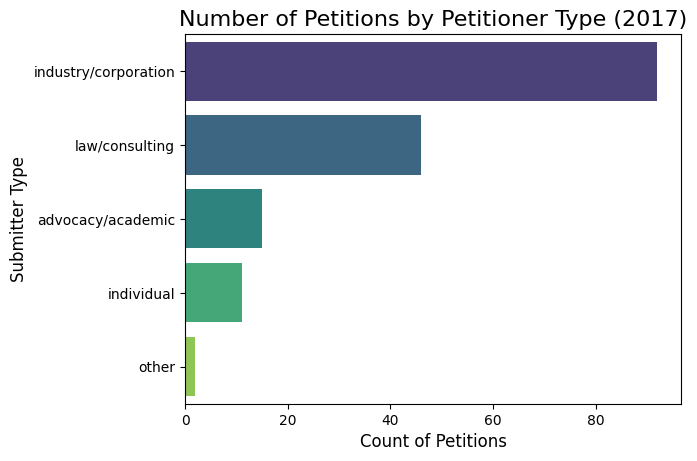

In [4]:
# IMPORTANT: only plot petitions that did not have a withdrawal letter
exclude_withdrawals_petit = df[df["Was_Withdrawn"] == False]
exclude_withdrawals_petit.to_csv("exclude_withdrawals_petitions.csv", index=False)

# count of petitions by submitter type 
order = exclude_withdrawals_petit["Submitter Type"].value_counts().index
sns.countplot(data = exclude_withdrawals_petit, y = "Submitter Type", order = order, palette = "viridis")
plt.title('Number of Petitions by Petitioner Type (2017)', fontsize=16)
plt.xlabel('Count of Petitions', fontsize=12)
plt.ylabel('Submitter Type', fontsize=12)

#### Quick Analysis of Bar Plot:
* most petitions are filled out by either industry/corps or law/consulting
* individuals having the least 

/var/folders/w1/yj3_r24s4tl7vlj_flvb3ntm0000gn/T/ipykernel_35956/2920394257.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data = exclude_withdrawals_petit, x = "Response Time (Days)", y = "Submitter Type", order = order, palette = "plasma")


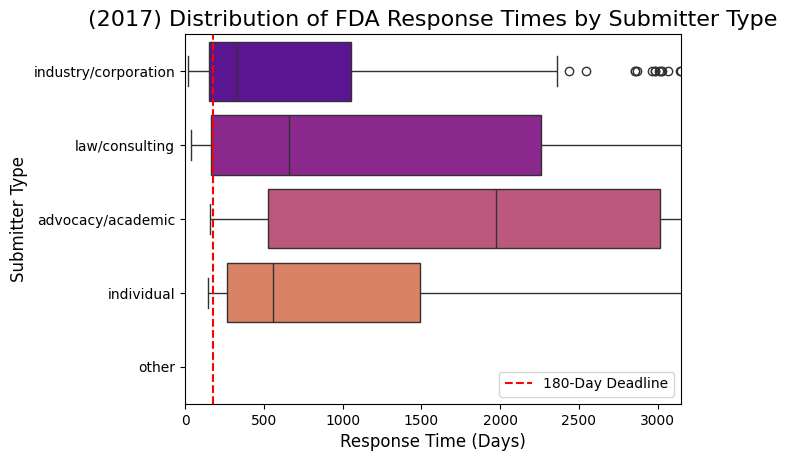

In [5]:
# response time by submitter type 
sns.boxplot(data = exclude_withdrawals_petit, x = "Response Time (Days)", y = "Submitter Type", order = order, palette = "plasma")
plt.title("(2017) Distribution of FDA Response Times by Submitter Type", fontsize=16)
plt.xlabel('Response Time (Days)', fontsize=12)
plt.ylabel('Submitter Type', fontsize=12)

# Gemini code below
# Limit x-axis to the 95th percentile for better readability, ignoring negative times
plt.xlim(0, df[df["Response Time (Days)"] >= 0]["Response Time (Days)"].quantile(0.95))
plt.axvline(x = 180, color = 'r', linestyle = '--', label = '180-Day Deadline')
plt.legend()

(Oct 8 fixed using corpus) keep in mind that other category includes individuals bc haven't figured out to separate them

#### Quick Analysis of Box Plot (Revised after recleaning data):
* median line splits the data exactly 50/50
  * industry/corp get fastest responses bc (1) median line is closes to the 180-day deadline and (2) middle 50% of data (the box) is not very spread out (compared to the others), meaning they get responses around the 180-1000 days mark (possible to extract the exact q values)
  * adv/acad have the most delayed response time from the fda bc of median line being the furthest and spread of data, followed by law/consulting
  * individual's median line and spread of data is worse than indus/consult, but better than avd/acad & law/consulting
* box itself is middle 50% (boxplot is split into 25/25/25/25 -> box is middle 50)
  * industry/corp's and individual's middle 50% of data have the least spread; data mostly around the 180-1500 deadline which is kind of good bc fda usually responds in around 180-1500 days
* dots are outliers, end of whiskers show minimum and maximum

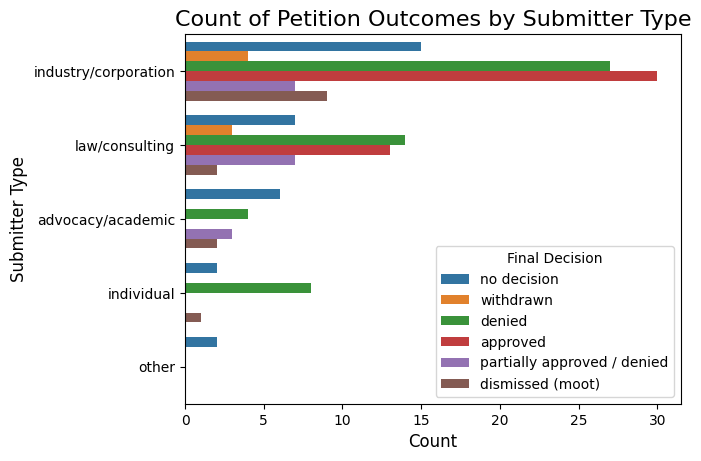

In [6]:
# stacked bar plot of count of petition final decision by submitter type
sns.countplot(data = exclude_withdrawals_petit, y = "Submitter Type", hue = "Cleaned Final Decision", order = order)

plt.title("Count of Petition Outcomes by Submitter Type", fontsize=16)
plt.xlabel("Count", fontsize=12)
plt.ylabel("Submitter Type", fontsize=12)
plt.legend(title = "Final Decision")

#### Quick Analysis:
note that each grouping is not standardized, so obviously industry/consult would have more decisions because they make up most of the petitions that were filed
* important decision to look at would be "no decsion" (blue) which is prevalents between all the categories
* adv/acad & individual not even getting any approvals, only denials or partials (but individuals not even getting partials)

#### Visualizations to prepare for inference model

Text(0.5, 1.0, 'Distribution of Response Times')

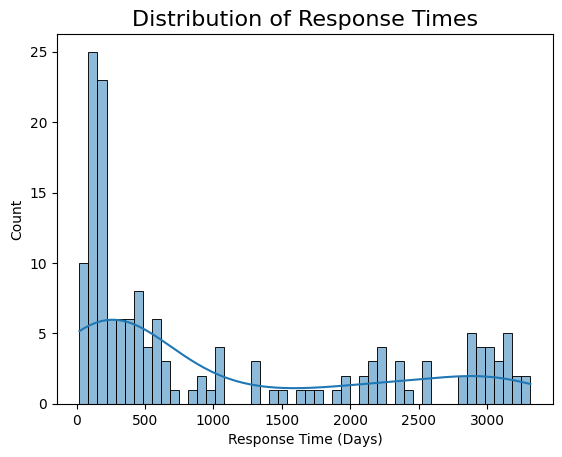

In [7]:
d = exclude_withdrawals_petit[exclude_withdrawals_petit["Response Time (Days)"] > 0]
sns.histplot(d["Response Time (Days)"].dropna(), kde = True, bins = 50)
plt.title("Distribution of Response Times", fontsize=16)

long tail stretching to the right:
* a decent amount of petitions getting super delayed response time
* supports paper because AHM was able to push forward because of long wait times



In [8]:
#exclude_withdrawals_petit[exclude_withdrawals_petit["Response Time (Days)"] <= 0]

**(FIXED) QUESTION/PROBLEM 2:** can i not consider any reconsideration petitions?
reason for negative response time:
* recall how response time is calculate
`(df["Response Time (Days)"] = (df["Last Response Date"] - df["Date of Petition"]).dt.days'`
* negative if "Last Response Date" is smaller but how can it be smaller if its the response date (responses should be after date of petition)? because of petitions that have reconsideration files (ex the two above)
* this means that the final version df has 2 rows, one with the date of actual petition and one with date of reconsideration, both have the last response date of the actual petition
* so these two specific rows above are the reconsideration files which means their dates are later/bigger compared to the "last response date" that was extracted from the actual petition


#### more analysis of distribution plot
* exploring the response times that peaked below
* conclusion for histogram: most responses take around 150-180 days which is really good bc the fda is pretty efficient for the most part, but can't exclude the heavy tail that spread all the way to 2500 days

In [9]:
stats = d["Response Time (Days)"].describe()
stats

count     160.000000
mean     1060.868750
std      1123.842237
min        20.000000
25%       160.750000
50%       432.500000
75%      2142.500000
max      3317.000000
Name: Response Time (Days), dtype: float64

In [10]:
q1 = stats["25%"]
q2 = stats["50%"]

print(f"The central peak of response times is between {q1:.0f} and {q2:.0f} days.")

peak_df = exclude_withdrawals_petit[(exclude_withdrawals_petit["Response Time (Days)"] >= q1) & 
                       (exclude_withdrawals_petit["Response Time (Days)"] <= q2)]

len(peak_df)

The central peak of response times is between 161 and 432 days.


40

#### conclusions for histogram and boxplot:
* see that there is a possible association between submitter type and shorter/longer response time -> will be a good paramter in inference model
* histogram further supports that there is a problem with fda's response time

#### further consideration for plots before modeling:
* response time vs interim
* requested action (vectorized) vs interim to see any possible association between certain "type" of petition (simpler vs complex - ask if there any suggested categories for petitions)

/var/folders/w1/yj3_r24s4tl7vlj_flvb3ntm0000gn/T/ipykernel_35956/2712651957.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data = d, x = "Count of Interim", y = "Response Time (Days)", palette = "muted")


Text(0.5, 1.0, 'Response Time vs. Number of Interim Responses')

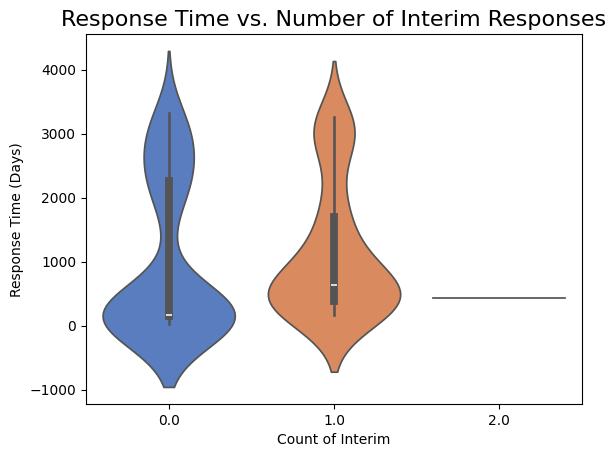

In [11]:
sns.violinplot(data = d, x = "Count of Interim", y = "Response Time (Days)", palette = "muted")
plt.title("Response Time vs. Number of Interim Responses", fontsize=16)

In [12]:
df[df["Count of Interim"] == 2]

,File ID,Petition File Name,Date of Petition,Was_Withdrawn,Document Type,Submitter,Submitter Type,Petition Cited Statutes or Regulations,FDA Action Commented On,Requested Action,...,Count of Interim,Responding FDA Center (of Final Decision),Responses Cited Statutes or Regulations,Justification for Interim Response,Justification for Final Response,Cleaned Final Decision,Year,Received Final Decision,Response Time (Days),Cleaned FDA Responding Center
54,fda-2017-p-2229,FDA-2017-P-2229-0001_Citizen_Petition_from_Cov...,2017-04-07,False,original petition,Covington & Burling LLP,law/consulting,- 21 C.F.R. § 10.30 – Citizen petition procedu...,FDA’s enforcement policy concerning listing of...,- Clarify that listing in the NDC Directory do...,...,2.0,Center for Food Safety and Applied Nutrition (...,- 21 CFR 101.9(c)(6)(i)\n- 21 CFR 10.30\n- 21 ...,- The FDA acknowledged receipt of the petition...,- The FDA emphasized that its definition of di...,denied,2017,True,432.0,CFSAN


In [13]:
df[df["Response Time (Days)"] < 0]

,File ID,Petition File Name,Date of Petition,Was_Withdrawn,Document Type,Submitter,Submitter Type,Petition Cited Statutes or Regulations,FDA Action Commented On,Requested Action,...,Count of Interim,Responding FDA Center (of Final Decision),Responses Cited Statutes or Regulations,Justification for Interim Response,Justification for Final Response,Cleaned Final Decision,Year,Received Final Decision,Response Time (Days),Cleaned FDA Responding Center


#### Quick Analysis of Violin Plot:
* entire violin for 1 interim response is positioned much higher on the plot than the violin for 0; this means the response times for 1 interim are generally much longer (supports NO interim = shorter response time)
* box for the data that had 1 interim shows that most of the data get less variability in response times than those with no interim bc of the spread (supports YES interim = shorter response time)
* however the median line for those with 0 interim shows that they get a faster median response time compared to 1 interim (supports NO interim = shorter response time)
* once again the problem is the long tail that goes nearly all the way to 4000 for both interims

so this means that there is conflicting info on whether getting an interim or not will result in longer/shorter waitimes 


/var/folders/w1/yj3_r24s4tl7vlj_flvb3ntm0000gn/T/ipykernel_35956/1096371738.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=exclude_withdrawals_petit, x = "Response Time (Days)", y = "Cleaned FDA Responding Center", palette = "deep", fliersize=0) # fliersize=0 hides outliers; stripplot shows them


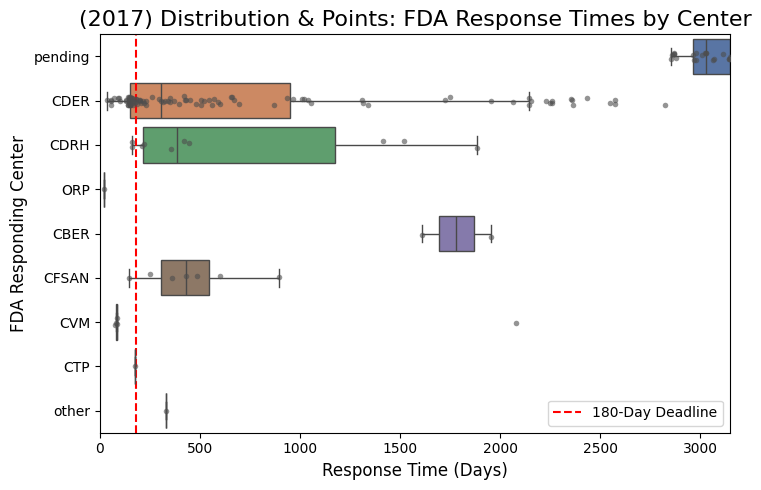

In [14]:
plt.figure(figsize=(7.5, 5))

sns.boxplot(data=exclude_withdrawals_petit, x = "Response Time (Days)", y = "Cleaned FDA Responding Center", palette = "deep", fliersize=0) # fliersize=0 hides outliers; stripplot shows them

# overlay the datapoints
sns.stripplot(data=exclude_withdrawals_petit, x = "Response Time (Days)", y = "Cleaned FDA Responding Center", color=".3", size=4, alpha=0.6) 

plt.title("(2017) Distribution & Points: FDA Response Times by Center", fontsize=16)
plt.xlabel("Response Time (Days)", fontsize=12)
plt.ylabel("FDA Responding Center", fontsize=12)

# Gemini Code for drawing 180 day line
plt.xlim(0, df[df["Response Time (Days)"] >= 0]["Response Time (Days)"].quantile(0.95))
plt.axvline(x=180, color = 'r', linestyle = '--', label='180-Day Deadline')
plt.legend()
plt.tight_layout()
plt.show()

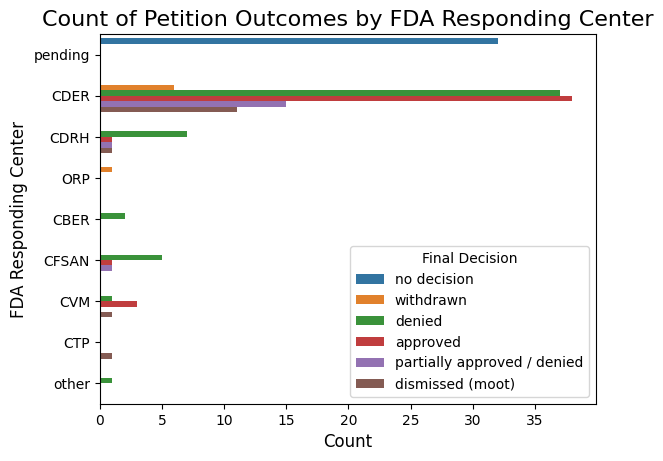

In [15]:
sns.countplot(data = exclude_withdrawals_petit, y = "Cleaned FDA Responding Center", hue = "Cleaned Final Decision")

plt.title("Count of Petition Outcomes by FDA Responding Center", fontsize=16)
plt.xlabel("Count", fontsize=12)
plt.ylabel("FDA Responding Center", fontsize=12)
plt.legend(title = "Final Decision")

#### Quick Analysis of Both:
**Slowest Centers:** based on the median line, CDER, CDRH, CBER, and CFSAN have the longest response times; medians are way past the 180-day deadline line

**Highest Volume:** CDER handles the vast majority of petitions (shown by the density of the datapoints and also the barplot); mostly likely means that large volume contributes to longer processing times compared to centers with fewer petitions

**"OK" Response Times:** other centers (ORP, CVM, CTP, other) do appear faster; medians seem to be closer to or below the 180-day line
* though notice that these categories also have far fewer datapoints/petitions -> this means our estimate of their "typical" time is less certain than for centers like CDER (issue might be resolved when dataset from diff years are added)

In [16]:
# no_decision_petitions = df[df["Cleaned Final Decision"] == "no decision"]["File ID"]
# no_decision_petitions.to_csv("no_decision_petitions.csv", index=False)
# no_decision_petitions

In [17]:
# no_decision_df = df[df["Cleaned Final Decision"] == "no decision"]
# no_decision_df.to_csv("no_decision_df.csv", index=False)
# no_decision_df

# Oct 28: Building Cox Proportional Hazards Model

**features in model:**
* submitter type
* count of interim
* responding fda center
* document type (og or recon, might be more useful when adding the datasets of diff years)
* year (more useful when adding the datasets of diff years)

In [66]:
%pip install lifelines
%pip install scikit-learn
%pip install jinja2


Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [jinja2]

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [67]:
from lifelines import CoxPHFitter
from sklearn.preprocessing import OneHotEncoder

In [68]:
# dataset that will be used
exclude_withdrawals_petit.head()

,File ID,Petition File Name,Date of Petition,Was_Withdrawn,Document Type,Submitter,Submitter Type,Petition Cited Statutes or Regulations,FDA Action Commented On,Requested Action,...,Count of Interim,Responding FDA Center (of Final Decision),Responses Cited Statutes or Regulations,Justification for Interim Response,Justification for Final Response,Cleaned Final Decision,Year,Received Final Decision,Response Time (Days),Cleaned FDA Responding Center
0,fda-2017-p-0052,FDA-2017-P-0052-0001_Citizen_Petition_from_Don...,2017-01-01,False,original petition,Donor Sibling Registry,advocacy/academic,- 21 C.F.R. § 10.20\n- 21 C.F.R. § 10.30\n- 21...,Lack of regulation and oversight in the sperm ...,The petitioner asks the FDA Commissioner to in...,...,0.0,NaN,NaN,NaN,NaN,no decision,2017,False,3209.0,pending
1,fda-2017-p-0115,FDA-2017-P-0115-0001_Citizen_Petition_from_Jub...,2016-12-22,False,original petition,Jubilant Generics Limited,industry/corporation,- Section 505(j)(2)(C) of the FD&C Act [21 U.S...,FDA’s requirement to approve an ANDA petition ...,FDA is requested to determine that Levetiracet...,...,0.0,Center for Drug Evaluation and Research (CDER),Not applicable.,NaN,- FDA contacted the petitioner (Jubilant Gener...,withdrawn,2017,True,2363.0,CDER
3,fda-2017-p-0176,FDA-2017-P-0176-0001_Citizen_Petition_from_Ame...,2017-01-09,False,original petition,"Kleinfeld, Kaplan and Becker, LLP",law/consulting,- 21 C.F.R. § 10.30 (Citizen Petition procedur...,The FDA’s proposed amendment to 21 C.F.R. § 10...,AHPA requests that FDA:\n1. Withdraw the propo...,...,1.0,NaN,NaN,The FDA stated the petition is under active ev...,NaN,no decision,2017,False,3201.0,pending
4,fda-2017-p-0290,FDA-2017-P-0290-0001_Citizen_Petition_from_Mal...,2017-01-17,False,original petition,Malaysian Rubber Export Promotion Council (MREPC),advocacy/academic,- FDA Docket No. FDA-2015-N-5017 (Final Rule)\...,The FDA’s Final Rule banning powdered surgeon’...,MREPC requests a two-month extension of the Fi...,...,0.0,Center for Devices and Radiological Health (CD...,"- 21 CFR 1.94, 21 CFR 1.95, 21 CFR 1.96\n- 21 ...",NaN,- The FDA determined that powdered surgeon’s g...,denied,2017,True,160.0,CDRH
6,fda-2017-p-0428,FDA-2017-P-0428-0001_Citizen_Petition_From_Muc...,2017-01-20,False,original petition,Mucodel Pharma LLC,industry/corporation,"- Federal Food, Drug, and Cosmetic Act\n- 21 C...",The FDA’s approval process for intranasal (IN)...,The petitioner requests the FDA to refrain fro...,...,0.0,Office of Regulatory Policy (ORP),Not applicable.,NaN,The original petition was voluntarily withdraw...,withdrawn,2017,True,20.0,ORP


In [79]:
def ohe(data, col):
    # one-hot-encodes categorical features
    oh_enc = OneHotEncoder(drop = "first", sparse_output = False)
    encoded_features = oh_enc.fit_transform(data[[col]])

    # df contains ONLY the new OHE columns
    encoded_cols_df = pd.DataFrame(encoded_features,
                                   columns=oh_enc.get_feature_names_out([col]),
                                   index=data.index)

    data_wo_og_col = data.drop(columns=[col])
    ohe_data = data_wo_og_col.join(encoded_cols_df)

    return ohe_data

# remove "Year", "Cleaned FDA Responding Center" columns FOR NOW because low variance (model will error)
data_encoded = exclude_withdrawals_petit[["Submitter Type", "Document Type", "Count of Interim", "Response Time (Days)", "Received Final Decision"]].dropna().copy()
data_encoded = ohe(data_encoded, "Submitter Type")
#data_encoded = ohe(data_encoded, "Cleaned FDA Responding Center")
data_encoded = ohe(data_encoded, "Document Type")

nan_counts = data_encoded.isnull().sum()

# Print columns that STILL have NaNs
# print("Columns with remaining NaN values:")
# print(nan_counts[nan_counts > 0])

# display(exclude_withdrawals_petit[pd.isna(exclude_withdrawals_petit["Response Time (Days)"])][["File ID", "Date of Petition", "Last Response Date", "Response Time (Days)"]])
# display(exclude_withdrawals_petit[pd.isna(exclude_withdrawals_petit["Count of Interim"])][["File ID", "Date of Petition", "Last Response Date", "Response Time (Days)", "Count of Interim"]])

# display(data_encoded[data_encoded["Response Time (Days)"] <= 0])
# print(data_encoded.info())

# --- Add these checks right before the 'try:' block for cph.fit() ---

print("Debugging Checks Before Fitting (model is sensitive)")

# check NaNs in the final df
print("Checking for NaNs:")
nan_counts_final = data_encoded.isnull().sum()
print(nan_counts_final[nan_counts_final > 0])
if nan_counts_final.sum() > 0:
    print("Error: NaNs still present!")

# check for nfinite values
print("\nChecking for Infinite values:")
inf_check = data_encoded.isin([np.inf, -np.inf]).sum()
print(inf_check[inf_check > 0])
if inf_check.sum() > 0:
    print("Error: Infinite values detected!")

# 3. check data types 
print("\nChecking data types again:")
print(data_encoded.info())

# 4. examine duration and event columns specifically
print("\nSummary statistics for Duration and Event:")
print(data_encoded[["Response Time (Days)", "Received Final Decision"]].describe())

print("\nValue counts for Event column:")
print(data_encoded["Received Final Decision"].value_counts())

Debugging Checks Before Fitting (model is sensitive)
Checking for NaNs:
Series([], dtype: int64)

Checking for Infinite values:
Series([], dtype: int64)

Checking data types again:
<class 'pandas.core.frame.DataFrame'>
Index: 160 entries, 0 to 200
Data columns (total 7 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Count of Interim                     160 non-null    float64
 1   Response Time (Days)                 160 non-null    float64
 2   Received Final Decision              160 non-null    bool   
 3   Submitter Type_individual            160 non-null    float64
 4   Submitter Type_industry/corporation  160 non-null    float64
 5   Submitter Type_law/consulting        160 non-null    float64
 6   Document Type_reconsideration        160 non-null    float64
dtypes: bool(1), float64(6)
memory usage: 8.9 KB
None

Summary statistics for Duration and Event:
       Response Time (Days)


In [80]:
# verify the required columns exist
required_cols = ["Response Time (Days)", "Received Final Decision"]
if not all(col in data_encoded.columns for col in required_cols):
    print(f"Error: Missing required columns. Ensure 'Response Time (Days)' and 'Received Final Decision' are in the DataFrame.")
    print("Available columns:", data_encoded.columns)
else:
    # create the cox model object 
    # creates an empty model ready to be trained
    cph = CoxPHFitter()
    print("CoxPHFitter object created.")

    # fit model to my data
    try:
        cph.fit(data_encoded,
                duration_col = "Response Time (Days)",
                event_col = "Received Final Decision")

        print("\nModel fitting complete!")

        # view results 
        # print_summary() method displays the main results table
        print("\n--- Cox Proportional Hazards Model Summary ---")
        cph.print_summary(decimals=3) # decimals=3 controls rounding

    except Exception as e:
        print(f"\nAn error occurred during model fitting: {e}")
        print("This might be due to remaining NaN values, non-numeric data, or issues with the duration/event columns.")
        print("Double-check the output of Step 2 (data preparation).")

CoxPHFitter object created.

Model fitting complete!

--- Cox Proportional Hazards Model Summary ---


<lifelines.CoxPHFitter: fitted with 160 total observations, 26 right-censored observations>
             duration col = 'Response Time (Days)'
                event col = 'Received Final Decision'
      baseline estimation = breslow
   number of observations = 160
number of events observed = 134
   partial log-likelihood = -588.545
         time fit was run = 2025-10-29 17:48:39 UTC

---
                                      coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                             
Count of Interim                    -0.298     0.743     0.176          -0.642           0.047               0.526               1.048
Submitter Type_individual            0.645     1.906     0.479          -0.294           1.584               0.746               4.872
Submitter Type_industry/corporation  0.763     2.144     0.353           0.070           1.455               1.073               4.286
Submitter Type_law/consulting        0.524     1.690     0.370          -0.202           1.250               0.817               3.492
Document Type_reconsideration        0.735     2.085     0.527          -0.298           1.767               0.742               5.854

                                     cmp to      z     p  -log2(p)
covariate                                                         
Count of Interim                      0.000 -1.692 0.091     3.463
Submitter Type_individual             0.000  1.347 0.178     2.490
Submitter Type_industry/corporation   0.000  2.159 0.031     5.019
Submitter Type_law/consulting         0.000  1.416 0.157     2.673
Document Type_reconsideration         0.000  1.395 0.163     2.616
---
Concordance = 0.643
Partial AIC = 1187.090
log-likelihood ratio test = 11.356 on 5 df
-log2(p) of ll-ratio test = 4.482

### RECALL:
**Interpretation of Hazard Ratios (HR):** (different from OLS coefficients)

* model estimates coefficients (log-hazard ratios) -> usually exponentiate them (exp(coefficient)) to get the hazard ratio
* **HR = 1:** this factor has no effect on how quickly a decision is reached
* **HR > 1:** this factor *increases* the hazard rate ie. petitions with this factor tend to get a final decision faster (shorter wait times) compared to the baseline, holding other factors constant
* **HR < 1:** this factor *decreases* the hazard rate ie. petitions with this factor tend to get a final decision slower (longer wait times) compared to the baseline, holding other factors constant
* **magnitude:** the further the HR is from 1, the stronger the association
    * HR of 0.5: hazard is cut in half (takes roughly twice as long to get a decision) vs. HR of 2.0: hazard is doubled (takes roughly half as long)

---
### Assessing Statistical Significance (p-values for Hazard Ratios)

**Set Significance Level ($\alpha$):** choose a threshold (0.05 aka 5%) to decide if an association is statistically significant; basically a baseline for deciding when to reject the null 

**Hypotheses PER Feature:**

**Null Hypothesis:** the true hazard ratio for this specific feature is equal to 1 (i.e. this feature provides no increase/decrease in the hazard rate compared to the baseline)
**Alternative Hypothesis:** true HR for this specific feature is not equal to 1 (i.e. this feature is associated with either an increase (HR > 1) or decrease (HR < 1) in the hazard rate)
**Evaluate p-value:** for each feature, the model will give a p-value for its coefficient (log-hazard ratio).
* **p-value < $\alpha$**: reject null; conclude there is **statistically significant evidence** that this feature is associated with the response time (hazard rate), i.e. *under the null*, the observed association was unlikely to happen (aka it unlikely to happen under the null), so reject null
* **p-value >= $\alpha$**: fail to reject; there is **not enough statistical evidence** to say this feature is significantly associated with the response time at this significance level

**Note:** a small p-value indicates *confidence* that an association exists, **not** the *strength* of that association (this is the hazard ratio itself, look at previous section)

**Count of Interim:**

HR = 0.743 (< 1)

p = 0.091 (> 0.05)

Interpretation: 
* receiving an interim response is associated with a slower rate of getting a final decision (HR < 1)
* but this result is not statistically significant at the 0.05 level; not enough evidence in this model to confidently say interim responses slow things down after accounting for other factors

**Submitter Type_individual:**

HR = 1.906 (> 1)

p = 0.178 (> 0.05)

Interpretation: 
* compared to the baseline group (likely "avd/aca" bc it's first alphabetically and used drop_first=True), individuals appear to get decisions faster (HR > 1)
* not statistically significant

**Submitter Type_industry/corporation:**

HR = 2.144 (> 1)

p = 0.031 (< 0.05)

Interpretation: 
* compared to the baseline group, industry/corp petitioners have a hazard rate about 2.14 times higher, meaning they tend to get final decisions significantly faster
* statistically significant

**Submitter Type_law/consulting:**

HR = 1.690 (> 1)

p = 0.157 (> 0.05)

Interpretation: 
* compared to the baseline group, law/consult petitioners appear to get decisions faster 
* not statistically significant

**Document Type_reconsideration:**

HR = 2.085 (> 1)

p = 0.163 (> 0.05)

Interpretation: 
* compared to original petitions, reconsideration petitions appear to get decisions faster
* not statistically significant

**Overall**

for the features that have p-values < 0.05, there is not enough statistical evidence at the 0.05 significance level to conclude that this feature is associated with the response time (HOWEVER might change once i add the datasets for diff years)

In [83]:
# data = exclude_withdrawals_petit[["Submitter Type", "Document Type", "Count of Interim", "Response Time (Days)", "Received Final Decision"]]
# nan_counts = data.isnull().sum()

# # Print columns that STILL have NaNs
# print("Columns with remaining NaN values:")
# print(nan_counts[nan_counts > 0])

# display(exclude_withdrawals_petit[pd.isna(exclude_withdrawals_petit["Response Time (Days)"])][["File ID", "Date of Petition", "Last Response Date", "Response Time (Days)"]])
# display(exclude_withdrawals_petit[pd.isna(exclude_withdrawals_petit["Count of Interim"])][["File ID", "Date of Petition", "Last Response Date", "Response Time (Days)", "Count of Interim"]])

# # display(data_encoded[data_encoded["Response Time (Days)"] <= 0])
# # print(data_encoded.info())